**FINAL USE CASE: DIMENSIONALITY REDUCTION & CLUSTERING**

**PROJECT I** 

**Team members: ADAMU Farida / FAY Alexandre / KARGINA Yulia / MOHANADAS Maxime**

Date: April 18th, 2023

**PROJECT I:**
*Three data extracts containing staff skills, educational qualifications & job profile / grades have been provided to you. Cluster the samples provided, analyse, and present each cluster.*

**Four steps:** 

- (a) Data Preparation & Cleaning: Consolidate the different extracts into a single dataset ;

- (b) Analysis of the features: Identify the feature scope and data types ;

- (c) Clustering techniques: Select the right clustering algorithm ;

- (d) Presentation of results.


**PRESENTATION OF THE DATA:**
The data consists of **three extracts** in an Excel file called *"StaffList"*. 

- The first extract contains information on **the individual skills of staff members**, including a unique 'RecordID' for each staff member ; 

- The second extract contains information on **job profiles**, including management level and home country, also identified by a unique 'RecordID'. 

- The third extract contains information on **educational qualifications**, including school name, field of study, years attended, and highest qualification attained (yes or no).


**PROBLEM STATEMENT:**
Based on the information provided, it seems like the **key problem** is to:
*Identify clusters within the staff based on their skills, educational qualifications, and job profiles/grades.* 

=> This can help identify groups of staff members who may have **similar skillsets or job roles**, and could potentially **inform decisions around hiring, training, or organizational structure**. 

=> The challenge would be to **identify meaningful clusters** that provide **actionable insights for the organization**.


In [1]:
# Import Libraries:
import pandas as pd                               #Load datasets & clean dataframe
from kmodes.kprototypes import KPrototypes        #Run k prototypes algorithm
import matplotlib.pyplot as plt                   #Plot outputs
from wordcloud import WordCloud                   #Running Wordclouds
from sklearn.preprocessing import StandardScaler  #Standardization
from sklearn.decomposition import PCA             #PCA function

**I/ DATA PREPARATION & CLEANING**

**A) Consolidating tables into one**

In [2]:
# 1/ Consolidate the different extracts into a single dataset (1 row per sample):

    # Load data from Excel sheets into separate dataframes:
df_skills = pd.read_excel('StaffList.xlsx', sheet_name='Skills')
df_job_management = pd.read_excel('StaffList.xlsx', sheet_name='Job_Management')
df_education = pd.read_excel('StaffList.xlsx', sheet_name='Education')

    # Merge dataframes on the common key 'RecordID':
df = pd.merge(df_skills, df_job_management, on='RecordID')
df = pd.merge(df, df_education, on='RecordID')

**B) Cleansing**

In [3]:
# 2/ Cleansing

# Dealing with NA values:

    # Dropping all rows that contain "NA Values in few columns":
df.dropna(subset=['FirstYearAttended', 'LastYearAttended'], inplace=True)

    # Replacing NA values in categorical columns with "Unknown":
df[['All Skills', 'JobProfile', 'ManagementLevel', 'HomeCountry', 'SchoolName', 'Degree',  'HighestQualification']] = df[['All Skills', 'JobProfile', 'ManagementLevel', 'HomeCountry', 'SchoolName', 'Degree', 'HighestQualification']].fillna("Unknown")

    # Replace NaN values in FieldofStudy with "Other":
df[['FieldofStudy']] = df[['FieldofStudy']].fillna("Other")

**C) Dimensionality Reduction**

In [4]:
# 3 / Dimensionality Reduction: 

    # A/ Regarding the business problem and in order to ensure that the analysis is focused on the current workforce 
    # and their current skills and job profiles, it might be more relevant to focus on the most recent years of education 
    # and work experience. Therefore, we consider keeping data from the last 10 years.
    
# First, we should set both first and last year attended as integer:
df['FirstYearAttended'] = df['FirstYearAttended'].dt.year.astype(int)
df['LastYearAttended'] = df['LastYearAttended'].dt.year.astype(int)

# Keeping data from the last 10 years:
df = df[df['FirstYearAttended'] >= 2013]



In [5]:
   # B/ Categorization can help to reduce the dimensionality of the data, make it more manageable for clustering and it also improves the accuracy of the clustering algorithm.

# *EDUCATIONAL LEVEL*:
    # Replacing education levels with simplified categories:
df.loc[df['Degree'].str.contains('Master'), 'Degree'] = 'Master'
df.loc[df['Degree'].str.contains('Bachelor'), 'Degree'] = 'Bachelor'

# *SKILLS*: 
# Replacing all skills for Microsoft / Office Tools as "Microsoft":
df.loc[df['All Skills'].str.contains('Microsoft|Office Tools|Office 365|office 365|Pack Office|Pack office|pack office|Suite Office|OfficeSuite|MS Office|MS office|MS-Office|Office Pack'), 'All Skills'] = 'Microsoft'

# for Soft Skills:
df.loc[df['All Skills'].str.contains('Accountable|Adaptability|Communication|Creativity|Detail-Oriented|Relationships|Learning Quickly|Organizing|Proactive|Results-Oriented|Rigor|Initiative|Time Management|Thinking|Problem'), 'All Skills'] = 'Soft Skill'

# for Data Analysis:
df.loc[df['All Skills'].str.contains('Alteryx|AI|BI|Data|Excel|Microsoft|Analytics|Power Query|Machine Learning|Tableau|R-Studio|R|Digital Transformation'), 'All Skills'] = 'Data Analysis'

# for Language:
df.loc[df['All Skills'].str.contains('Anglais|English|French|German|Italian|Languages|Protuguese'), 'All Skills'] = 'Language'

In [6]:
    # C/ We are looking for staffs that know how to use tools that are commonly used in the industry or organization, 
    # we would like to remove the skills that appear less frequently (less than 5 times).
    
    # In other words, our objective is to identify clusters of staff members based on their skills 
    # and educational qualifications, it could be useful to focus on the skills that are most commonly found in the dataset.

    # Count the frequency of each skill in the "All Skills" column:
skill_counts = df['All Skills'].value_counts()
  
    # Create a boolean mask to filter rows where the skill count is greater than 5:
mask = df['All Skills'].isin(skill_counts[skill_counts > 5].index)

    # Apply the mask to the dataframe to keep the desired rows:
df = df[mask]

**C) Additional Variable for valuable information**

In [7]:
# 4/ Additional variable for valuable information:

# A new column "NbYearsOfEducation" can provide valuable information to help identifying potential skillsets, assessing the level of education, and informing decisions around training.

    # We can now add a column "NbYearsofEducation" showing the total number of years of education:
df['NbYearsOfEducation'] = df['LastYearAttended'] - df['FirstYearAttended'] + 1

*Run PCA Algorithm on numerical datatypes to get around 75% variance explained*

In [9]:
# Excluding non interest records from clustering algorithm:
# List of column names to exclude
cols_to_exclude = ['RecordID', 'SchoolName', 'Degree', 'FieldofStudy', 'HighestQualification', 'LastYearAttended']

# Exclude the columns from the DataFrame
df = df.loc[:, ~df.columns.isin(cols_to_exclude)]


Identify Categorical Variables.

In [10]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical variables in the DataFrame:
categorical_vars = ['All Skills','JobProfile','ManagementLevel', 'HomeCountry']

df2 = [col in categorical_vars for col in df.columns]

# Convert categorical variables to label-encoded representation:
df_encoded = df.copy()
for col in df.columns[df2]:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])

Identify Numeric Variables


In [11]:
# Identify numerical variables in the DataFrame:
numeric_vars = ['FirstYearAttended','NbYearsOfEducation']
df1 = [col in numeric_vars for col in df.columns]

# Standardize numeric variables:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numeric_vars])

THE ANALYSIS

Perform Principal Component Analysis

In [12]:
# Perform PCA on numeric variables:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_scaled = pd.DataFrame(data = df_pca,
                columns = ['PC1', 'PC2'] )

#Total variance % emplained by components
print("% variance explained by PC1, PC2:", round(sum(pca.explained_variance_ratio_[:3]) * 100, 2))

% variance explained by PC1, PC2: 100.0


Run K Prototype Algorthm

In [13]:
# Identify categorical variables in the DataFrame:
categorical_vars = ['All Skills','JobProfile','ManagementLevel', 'HomeCountry']
categorical_cols = [df.columns.get_loc(col) for col in categorical_vars]

# Run K-Prototypes algorithm:
k = 5  # Number of clusters
kp = KPrototypes(n_clusters=k, verbose=2)

# Convert categorical variables to label-encoded representation:
df_encoded = df.copy()
for col in categorical_vars:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])


Initialization method and algorithm are deterministic. Setting n_init to 1.


Merge Categorial and Numeriacl Variables 

In [14]:
# Reduced dataframe (Numeric(PCs 1 to 2) + categorical variables)

# Convert the lists to DataFrames
df1 = pd.DataFrame(numeric_vars, columns=['Numeric'])
df2 = pd.DataFrame(categorical_vars, columns=['Category'])

df_reduced = pd.merge(df1, df2, left_index=True, right_index=True)

# Prin
#df_reduced = pd.merge(df1, df2, left_index=True, right_index=True)

Fit the K- Prototype Model 

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Scale numerical variables
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_encoded)

# Fit K-Prototypes model
clusters = kp.fit_predict(df_scaled, categorical=categorical_cols)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 3970, ncost: 2984.151037400907
Run: 1, iteration: 2/100, moves: 641, ncost: 2977.752792567409
Run: 1, iteration: 3/100, moves: 105, ncost: 2977.6758362765295
Run: 1, iteration: 4/100, moves: 0, ncost: 2977.6758362765295
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 4047, ncost: 3000.7007426790155
Run: 2, iteration: 2/100, moves: 938, ncost: 2989.4228909835592
Run: 2, iteration: 3/100, moves: 213, ncost: 2987.2416327798855
Run: 2, iteration: 4/100, moves: 39, ncost: 2987.049785009603
Run: 2, iteration: 5/100, moves: 0, ncost: 2987.049785009603
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 4367, ncost: 3119.884416852594
Run: 3, iteration: 2/100, moves: 1364, ncost: 3101.954431138169
Run: 3, iteration: 3/100, moves: 378, ncost: 3100.8594742763203

In [16]:
# Add cluster labels to original dataframe
df['Cluster'] = clusters

REPRESENTING THE DATA

a. K-prototypes clustering

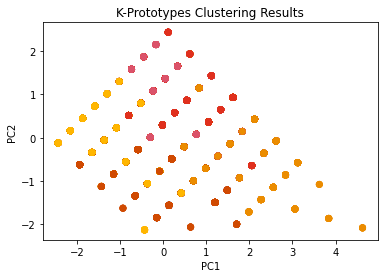

In [17]:
# Define the PwC color palette
color_palette = ['#FFB600','#DB536A','#D04A02','#EB8C00','#E0301E']

# Create the scatter plot with custom colors
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=[color_palette[label] for label in df['Cluster']])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Prototypes Clustering Results')
plt.show()


A Word cloud of Skills Cluster

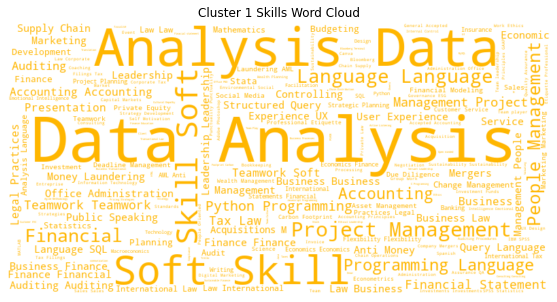

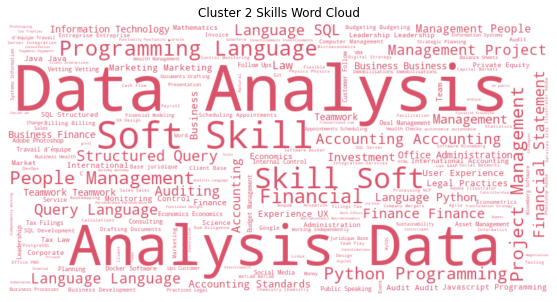

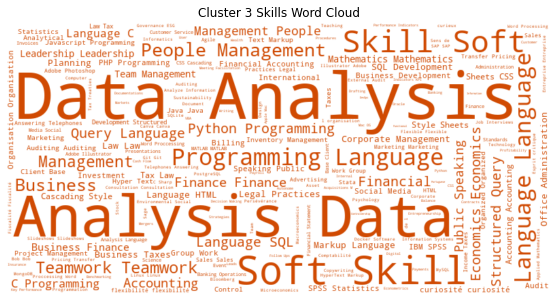

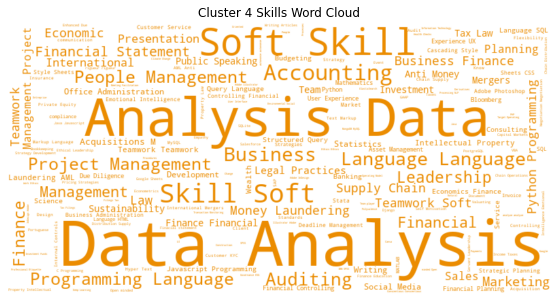

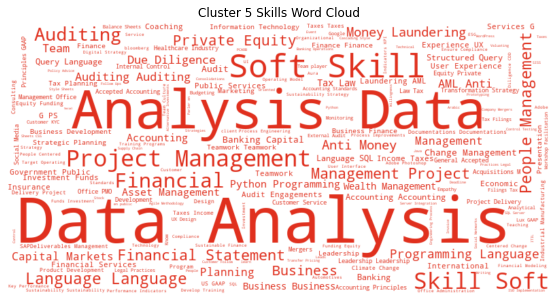

In [24]:
# Define the PwC color palette
color_palette = ['#FFB600','#DB536A','#D04A02','#EB8C00','#E0301E']

# Example: Word cloud of skills for each cluster with custom colors
for i in range(k):
    cluster_data = df[df['Cluster'] == i]
    skills = ' '.join(cluster_data['All Skills'].str.cat(sep=' ').split())
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=lambda *args, **kwargs: color_palette[i % len(color_palette)]).generate(skills)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {i+1} Skills Word Cloud')
    plt.show()


Management Level Clusters

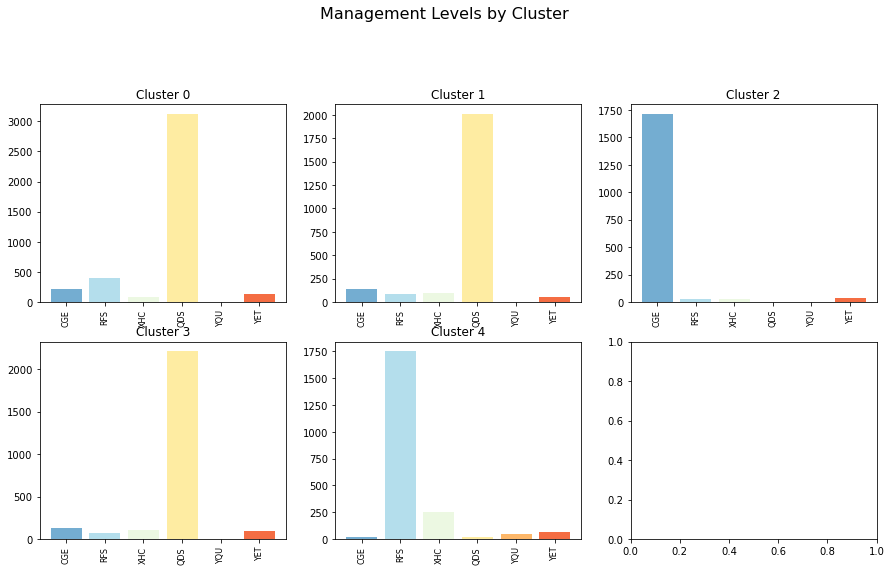

In [30]:

import seaborn as sns                             
import numpy as np
from sklearn.cluster import KMeans                


#Understand the distribution of Management level per cluster

cluster_0 = df[clusters == 0]
cluster_1 = df[clusters == 1]
cluster_2 = df[clusters == 2]
cluster_3 = df[clusters == 3]
cluster_4 = df[clusters == 4]

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(15,8))

# Get colors
colors = colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, 6))

# Set the colors for each management level
for i, lvl in enumerate(df['ManagementLevel'].unique()):
    if lvl in cluster_0['ManagementLevel'].value_counts().index:
        ax1.bar(i, cluster_0['ManagementLevel'].value_counts().loc[lvl], color=colors[i])
    if lvl in cluster_1['ManagementLevel'].value_counts().index:
        ax2.bar(i, cluster_1['ManagementLevel'].value_counts().loc[lvl], color=colors[i])
    if lvl in cluster_2['ManagementLevel'].value_counts().index:
        ax3.bar(i, cluster_2['ManagementLevel'].value_counts().loc[lvl], color=colors[i])
    if lvl in cluster_3['ManagementLevel'].value_counts().index:
        ax4.bar(i, cluster_3['ManagementLevel'].value_counts().loc[lvl], color=colors[i])
    if lvl in cluster_4['ManagementLevel'].value_counts().index:
        ax5.bar(i, cluster_4['ManagementLevel'].value_counts().loc[lvl], color=colors[i])

# Set the labels to the unique management levels
ax1.set_xticks(range(len(df['ManagementLevel'].unique())))
ax1.set_xticklabels(df['ManagementLevel'].unique())
ax2.set_xticks(range(len(df['ManagementLevel'].unique())))
ax2.set_xticklabels(df['ManagementLevel'].unique())
ax3.set_xticks(range(len(df['ManagementLevel'].unique())))
ax3.set_xticklabels(df['ManagementLevel'].unique())
ax4.set_xticks(range(len(df['ManagementLevel'].unique())))
ax4.set_xticklabels(df['ManagementLevel'].unique())
ax5.set_xticks(range(len(df['ManagementLevel'].unique())))
ax5.set_xticklabels(df['ManagementLevel'].unique())

ax1.set_title('Cluster 0')
ax2.set_title('Cluster 1')
ax3.set_title('Cluster 2')
ax4.set_title('Cluster 3')
ax5.set_title('Cluster 4')

plt.setp(ax1.get_xticklabels(), fontsize=8, rotation='vertical')
plt.setp(ax2.get_xticklabels(), fontsize=8, rotation='vertical')
plt.setp(ax3.get_xticklabels(), fontsize=8, rotation='vertical')
plt.setp(ax4.get_xticklabels(), fontsize=8, rotation='vertical')
plt.setp(ax5.get_xticklabels(), fontsize=8, rotation='vertical')

fig.suptitle('Management Levels by Cluster', fontsize=16, y=1.05)

plt.show()



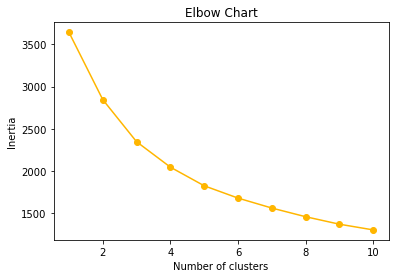

In [33]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

# Create list of inertias for different k values
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow chart
plt.plot(range(1, 11), inertias, marker='o', color='#FFB600')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Chart')
plt.show()
